In [1]:
# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LSTM, Bidirectional, Conv1D
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from copy import copy
from tensorflow.keras import backend as K
from sklearn import preprocessing
import tensorflow.keras.optimizers as optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

## Separate splits

In [2]:
def augument_sample(sample, averages, stds):
    return None

def format_data(df, lookback_window=12, only_features=False, to_drop=['total_cases'], lstm=False):
    x = []
    y = []
    x_data = df.copy()
    
    if only_features:
        x_data = x_data.drop(to_drop, axis=1)

    for i in range(len(df)-lookback_window):
        x_entry = copy(x_data[i:i+lookback_window].values.T) # include current value
        
        if not only_features:
            x_entry[0][lookback_window-1] = 0.0 # erase variable to be predicted
        
        if lstm:
            x.append(x_entry.T)
        else:
            x.append(x_entry)

        y_entry = df['total_cases'][i+lookback_window-1]
        y.append(y_entry)
        
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def split(x, y, val_size):
    train_size = len(x)-val_size
    x_train, y_train = x[0:train_size], y[0:train_size]
    x_val, y_val = x[train_size:train_size+val_size], y[train_size:train_size+val_size]
    
    assert y_train.shape[0]+y_val.shape[0] == len(y)
    
    return x_train, y_train, x_val, y_val

## Long Short-Term Memory (LSTM) model

In [18]:
def get_model(input_shape):
    i = Input(shape=(input_shape))
    print(i.shape)
    m = i
    m = LSTM(50, activation='relu')(m)
    m = Dense(500, activation='relu')(m)
    m = Dense(200, activation='relu')(m)
    m = Dense(1, activation='relu')(m)
    
    model = Model(inputs=[i], outputs=[m])

    optimizer=optimizers.Adam(lr=5e-6)
    model.compile(optimizer, 'mae')
    return model

In [5]:
def train_model(model, data, epochs=200, plot=True):
    start_time = time.time()
    print('Training...')
    x_train, y_train, x_val, y_val = data
    validation_data = (x_val, y_val)
    history = model.fit(x_train, y_train, epochs=epochs,
                        verbose=2, validation_data=validation_data, batch_size=50)
    elapsed_time = time.time() - start_time
    
    print("Elapsed Time: {}".format(elapsed_time))
    
    if plot:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        #plt.ylim(0, 40)
        plt.legend(loc='upper right')
        plt.show()

In [6]:
def plot_train_val(model, data):
    x_train, y_train, x_val, y_val = data
    p = model.predict(x_train)
    plt.plot(y_train, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

    p = model.predict(x_val)
    plt.plot(y_val, label='actual')
    plt.plot(p, label='predicted')
    plt.title('Weekly Dengue Cases')
    plt.legend()
    plt.show()

## Forecasting

In [7]:
def forecast(model, forecast_window, last_train, test_data):
    lookback_window = last_train.shape[1]
    current = np.expand_dims(last_train, axis=0)
    next_y = model.predict(current)[0][0]
    current[0][0][-1] = next_y
    
    result = []
    for xi in test_data:
        xi[0][0:lookback_window] = current[0][0][-lookback_window:]
        current = np.expand_dims(xi, axis=0)
        next_y = model.predict(current)[0][0]
        current[0][0][-1] = next_y
        result.append(next_y)
    
    return result
    
def fake_test_data(x_val):
    x_test = copy(x_val)
    for i in x_test:
        i[0] = 0.0
    return x_test

def forecast_analysis(model, data):
    x_train, y_train, x_val, y_val = data
    x_test = fake_test_data(x_val)
    result = forecast(model, len(x_test), copy(x_train[-1]), x_test) 
    
    error = mean_absolute_error(y_val, result)
    print("Forecast MAE: {}".format(error))

    plt.plot(y_val, label='actual')
    plt.plot(result, label='forecast')
    plt.title('Weekly Dengue Cases Forecasting')
    plt.legend()
    plt.show()
    return result

## Load data
- Load data from csv
- Merge dataframes
- Choose city
- Remove string columns

In [8]:
def load_data(lookback_window, city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    city_data = all_data[all_data.city == city]
    df = city_data.drop(['city', 'week_start_date'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def normalize_data(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(x)
    x_scaled = min_max_scaler.transform(x)
    df = pd.DataFrame(x_scaled, columns=df.columns)
    return df

## Model / Train / Forecast

In [9]:
K.clear_session()

## San Juan

In [22]:
train_split_percent = 0.65
lookback_window_sj = 170  # weeks.
df_sj = load_data(lookback_window_sj, city='sj')

df_sj = normalize_data(df_sj)

x, y = format_data(df_sj, lookback_window_sj, lstm=True)
print(x.shape)
print(y.shape)


val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

data = x_train, y_train, x_val, y_val

(766, 170, 23)
(766,)
(498, 170, 23)
(498,)
(268, 170, 23)
(268,)


(?, 170, 23)
Training...
Elapsed Time: 920.4081411361694


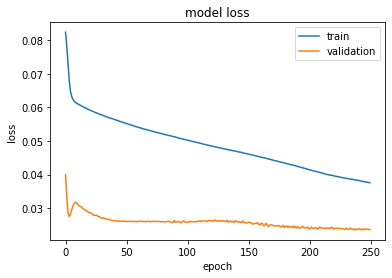

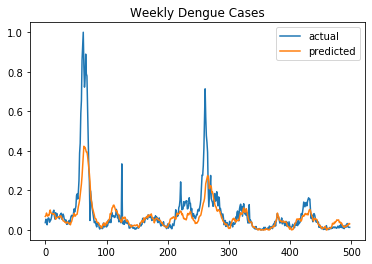

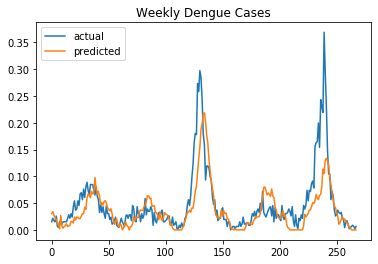

Forecast MAE: 0.023616499232121283


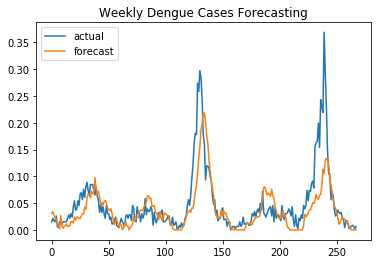

[0.030609505,
 0.03393367,
 0.027601944,
 0.022503743,
 0.018743189,
 0.014080392,
 0.007909199,
 0.002147818,
 0.026968597,
 0.0071593784,
 0.0031244364,
 0.0064631123,
 0.0077655315,
 0.011429923,
 0.0064377543,
 0.0072010364,
 0.008293191,
 0.015941182,
 0.015280936,
 0.012998614,
 0.023963867,
 0.018500486,
 0.024125079,
 0.023426628,
 0.020951046,
 0.021576399,
 0.025699079,
 0.03021628,
 0.030233078,
 0.042382594,
 0.03844749,
 0.05917976,
 0.06738053,
 0.06498902,
 0.05989177,
 0.07223282,
 0.06735428,
 0.06828316,
 0.09768644,
 0.07775372,
 0.0672822,
 0.07187772,
 0.062479705,
 0.047294356,
 0.050732754,
 0.046171647,
 0.05287683,
 0.054783203,
 0.05031159,
 0.041318342,
 0.038189318,
 0.035282534,
 0.039525945,
 0.030325383,
 0.019094232,
 0.010139307,
 0.016193895,
 0.020597119,
 0.011295394,
 0.005744042,
 0.010884328,
 0.009354908,
 0.00010718044,
 0.0035699233,
 0.010201061,
 0.014335048,
 0.007891504,
 0.006408818,
 0.0,
 0.0057814345,
 0.0066444073,
 0.0114836395,
 0.02

In [14]:
input_shape = (x.shape[1], x.shape[2])
model_sj = get_model(input_shape)
train_model(model_sj, data, epochs=250)
plot_train_val(model_sj, data)
forecast_analysis(model_sj, data)

## Iquitos

In [19]:
train_split_percent = 0.65
lookback_window_iq = 150  # weeks.
df_iq = load_data(lookback_window_iq, city='iq')

df_iq = normalize_data(df_iq)

x, y = format_data(df_iq, lookback_window_iq, lstm=True)
print(x.shape)
print(y.shape)

val_size = int(math.floor((len(x)*(1-train_split_percent))))
x_train, y_train, x_val, y_val = split(x, y, val_size)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
data = x_train, y_train, x_val, y_val

(370, 150, 23)
(370,)
(241, 150, 23)
(241,)
(129, 150, 23)
(129,)


(?, 150, 23)
Training...
Train on 241 samples, validate on 129 samples
Epoch 1/400
241/241 - 3s - loss: 0.0632 - val_loss: 0.0841
Epoch 2/400
241/241 - 2s - loss: 0.0612 - val_loss: 0.0806
Epoch 3/400
241/241 - 2s - loss: 0.0585 - val_loss: 0.0770
Epoch 4/400
241/241 - 2s - loss: 0.0552 - val_loss: 0.0742
Epoch 5/400
241/241 - 2s - loss: 0.0521 - val_loss: 0.0721
Epoch 6/400
241/241 - 2s - loss: 0.0493 - val_loss: 0.0704
Epoch 7/400
241/241 - 2s - loss: 0.0471 - val_loss: 0.0693
Epoch 8/400
241/241 - 2s - loss: 0.0456 - val_loss: 0.0688
Epoch 9/400
241/241 - 2s - loss: 0.0446 - val_loss: 0.0687
Epoch 10/400
241/241 - 2s - loss: 0.0440 - val_loss: 0.0688
Epoch 11/400
241/241 - 2s - loss: 0.0434 - val_loss: 0.0689
Epoch 12/400
241/241 - 2s - loss: 0.0431 - val_loss: 0.0690
Epoch 13/400
241/241 - 2s - loss: 0.0429 - val_loss: 0.0691
Epoch 14/400
241/241 - 2s - loss: 0.0428 - val_loss: 0.0691
Epoch 15/400
241/241 - 2s - loss: 0.0426 - val_loss: 0.0691
Epoch 16/400
241/241 - 2s - loss: 0.04

Epoch 136/400
241/241 - 2s - loss: 0.0376 - val_loss: 0.0686
Epoch 137/400
241/241 - 2s - loss: 0.0376 - val_loss: 0.0686
Epoch 138/400
241/241 - 2s - loss: 0.0376 - val_loss: 0.0686
Epoch 139/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0686
Epoch 140/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0686
Epoch 141/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0686
Epoch 142/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0685
Epoch 143/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0685
Epoch 144/400
241/241 - 2s - loss: 0.0375 - val_loss: 0.0685
Epoch 145/400
241/241 - 2s - loss: 0.0374 - val_loss: 0.0685
Epoch 146/400
241/241 - 2s - loss: 0.0374 - val_loss: 0.0685
Epoch 147/400
241/241 - 2s - loss: 0.0374 - val_loss: 0.0685
Epoch 148/400
241/241 - 2s - loss: 0.0374 - val_loss: 0.0685
Epoch 149/400
241/241 - 2s - loss: 0.0374 - val_loss: 0.0685
Epoch 150/400
241/241 - 2s - loss: 0.0373 - val_loss: 0.0685
Epoch 151/400
241/241 - 2s - loss: 0.0373 - val_loss: 0.0685
Epoch 152/400
241/241 - 

Epoch 271/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0679
Epoch 272/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0679
Epoch 273/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0678
Epoch 274/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0678
Epoch 275/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0678
Epoch 276/400
241/241 - 2s - loss: 0.0356 - val_loss: 0.0679
Epoch 277/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 278/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 279/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 280/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 281/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 282/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 283/400
241/241 - 2s - loss: 0.0355 - val_loss: 0.0678
Epoch 284/400
241/241 - 2s - loss: 0.0354 - val_loss: 0.0677
Epoch 285/400
241/241 - 2s - loss: 0.0354 - val_loss: 0.0678
Epoch 286/400
241/241 - 2s - loss: 0.0354 - val_loss: 0.0678
Epoch 287/400
241/241 - 

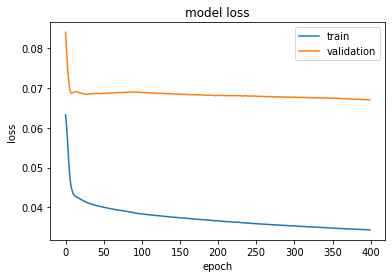

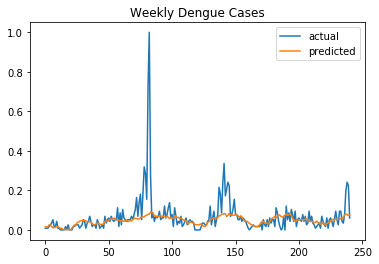

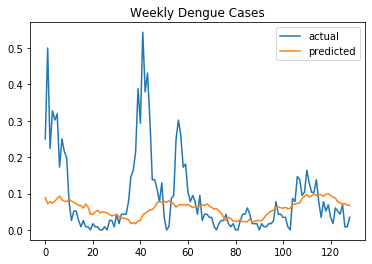

Forecast MAE: 0.06704732649868755


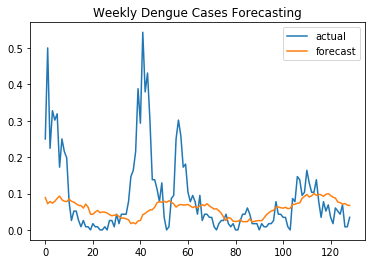

[0.08886165,
 0.07202663,
 0.07797585,
 0.07346444,
 0.078715,
 0.08660635,
 0.092992686,
 0.08276463,
 0.07888496,
 0.07774186,
 0.08445584,
 0.07898562,
 0.07622023,
 0.07161835,
 0.06731036,
 0.06683022,
 0.060009975,
 0.071018405,
 0.062611416,
 0.043308485,
 0.042592622,
 0.049316593,
 0.053484555,
 0.047449615,
 0.04925013,
 0.048773106,
 0.046402857,
 0.041924007,
 0.038779534,
 0.04057938,
 0.04144585,
 0.037347067,
 0.032137163,
 0.0325025,
 0.030505516,
 0.02774185,
 0.017473731,
 0.019997267,
 0.016727965,
 0.024640134,
 0.025940515,
 0.04159797,
 0.04537424,
 0.050823167,
 0.054666582,
 0.055578537,
 0.062349327,
 0.07448318,
 0.07788062,
 0.0758387,
 0.07856976,
 0.0759144,
 0.08023512,
 0.076462254,
 0.071561836,
 0.062529065,
 0.068192944,
 0.06960998,
 0.068493865,
 0.06854397,
 0.06985039,
 0.06576849,
 0.06149371,
 0.064125255,
 0.060842592,
 0.06606475,
 0.069510974,
 0.06643905,
 0.07188885,
 0.066018686,
 0.061822858,
 0.057339787,
 0.05812447,
 0.052451342,
 0.045

In [20]:
input_shape = (x.shape[1], x.shape[2])
model_iq = get_model(input_shape)
train_model(model_iq, data, epochs=400)
plot_train_val(model_iq, data)
forecast_analysis(model_iq, data)

In [23]:
## inverse normalize error 

new_df = load_data(lookback_window_sj, city='sj')
nx = new_df.total_cases.values.reshape(-1, 1) #returns a numpy array
min_max_scaler_2 = preprocessing.MinMaxScaler()
min_max_scaler_2.fit(nx)

error = min_max_scaler_2.inverse_transform(np.array(0.023616499232121283).reshape(-1, 1))
print("SJ Forecast MAE: {}".format(error))

ndf = load_data(lookback_window_iq, city='iq')
nx2 = ndf.total_cases.values.reshape(-1, 1) #returns a numpy array
min_max_scaler_3 = preprocessing.MinMaxScaler()
min_max_scaler_3.fit(nx2)

error = min_max_scaler_2.inverse_transform(np.array(0.06704732649868755).reshape(-1, 1))
print("IQ Forecast MAE: {}".format(error))

SJ Forecast MAE: [[10.88720615]]
IQ Forecast MAE: [[30.90881752]]
